# Projet Complet : Modélisation du Risque de Crédit & Analyse Prédictive
## Stage Data Science - Banque de Tunisie

**Auteur:** Emna Turki  
**Période:** 1 Juillet 2025 - 31 Août 2025  
**Département:** Gestion des Risques & Analyse de Données  

---

## Vue d'ensemble du projet

Ce notebook présente un projet complet de data science centré sur la **modélisation du risque de crédit** utilisant la modélisation stochastique et l'analyse prédictive.

### Sources de données:

**1. Données de Risque de Crédit** (`notes*.xlsx`)
- Objectif: Matrices de transition Markov, calculs ECL IFRS 9
- Colonnes: `CRIANNEE`, `CRIMOIS`, `CPGTID`, `CPGNID`, `CRICSDEF`, `rating`, `SNISGCOD`
- Période: 2019-2024
- Clients: 37,319 uniques

**2. Données d'Écoulement** (`data_ecoulement.xlsx`)
- Objectif: Analyse de survie, prévisions de taux d'écoulement
- Colonnes: `CPGANN`, `CPGMOIS`, `clt`, `encours_debut_modif`, `DEBIT`, `CREDIT`
- Objectif: Calculer la durée jusqu'à l'épuisement du solde

### Objectifs clés:
1. **Modélisation du Risque IFRS 9**: Matrices de transition Markov
2. **Analyse de Survie**: Modèles Kaplan-Meier et Weibull AFT
3. **Machine Learning**: Prévision des défauts de crédit
4. **Insights Business**: Patterns actionnables pour la gestion des risques

---
# Partie 1: Configuration et Bibliothèques
---

In [1]:
# Manipulation de données
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Analyse statistique
from scipy import stats
from scipy.stats import chi2_contingency, norm, skew, kurtosis

# Analyse de survie
from lifelines import (
    KaplanMeierFitter, 
    WeibullFitter, 
    ExponentialFitter, 
    LogNormalFitter, 
    LogLogisticFitter,
    WeibullAFTFitter
)
from lifelines.utils import median_survival_times

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, accuracy_score, f1_score
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('✓ Bibliothèques importées avec succès!')

✓ Bibliothèques importées avec succès!


---
# Partie 2: Chargement des Données
---

## 2.1 Source 1: Données de Risque de Crédit (pour les Chaînes de Markov)

**Colonnes:**
- `CRIANNEE`: Année
- `CRIMOIS`: Mois (3, 6, 9, 12 pour les trimestres)
- `CPGTID`: Code type client
- `CPGNID`: Numéro client
- `CRICSDEF`: Code de défaut crédit (0=S1, 1=S2, 2+=S3)
- `rating`: Label de notation
- `SNISGCOD`: Code additionnel

In [2]:
def load_credit_risk_data(base_path, years=[2019, 2020, 2021, 2022, 2023, 2024]):
    """
    Charger les données de risque de crédit depuis plusieurs fichiers Excel
    
    Retourne un DataFrame avec colonnes:
    - CLIENT_ID: Identifiant unique (CPGTID + CPGNID)
    - CRIANNEE: Année
    - CRIMOIS: Mois
    - STAGE: Stage crédit (S1/S2/S3)
    - CRICSDEF: Code de risque numérique
    """
    all_data = []
    
    for year in years:
        file_path = base_path.replace('2019', str(year))
        
        try:
            if os.path.exists(file_path):
                df = pd.read_excel(file_path)
                
                # Créer un ID client unique
                df['CLIENT_ID'] = df['CPGTID'].astype(str) + '_' + df['CPGNID'].astype(str)
                
                # Convertir CRICSDEF en stages IFRS 9 (vectorisé)
                df['STAGE'] = np.where(df['CRICSDEF'] == 0, 'S1',
                                     np.where(df['CRICSDEF'] == 1, 'S2', 'S3'))
                
                # Garder le code numérique original pour ML
                df['STAGE_NUM'] = df['CRICSDEF']
                
                all_data.append(df)
                print(f'✓ Chargé {year}: {len(df):,} enregistrements')
            else:
                print(f'✗ Fichier non trouvé: {file_path}')
                
        except Exception as e:
            print(f'✗ Erreur de chargement {year}: {str(e)}')
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n{'='*60}")
        print(f'Total enregistrements risque crédit: {len(combined_df):,}')
        print(f'Clients uniques: {combined_df["CLIENT_ID"].nunique():,}')
        print(f'Années: {sorted(combined_df["CRIANNEE"].unique())}')
        print(f'Utilisation mémoire: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
        print(f"{'='*60}")
        return combined_df
    else:
        raise ValueError('Aucune donnée de risque de crédit chargée!')

# Charger les données de risque de crédit
CREDIT_RISK_PATH = r'C:\Users\emnat\Desktop\DonneeProjetBT2\notes2019.xlsx'
df_credit_risk = load_credit_risk_data(CREDIT_RISK_PATH)

print('\nPremières 5 lignes:')
df_credit_risk[['CLIENT_ID', 'CRIANNEE', 'CRIMOIS', 'STAGE', 'CRICSDEF']].head()

✓ Chargé 2019: 347,758 enregistrements
✓ Chargé 2020: 350,633 enregistrements
✓ Chargé 2021: 352,937 enregistrements
✓ Chargé 2022: 359,593 enregistrements
✓ Chargé 2023: 361,698 enregistrements
✓ Chargé 2024: 377,317 enregistrements

Total enregistrements risque crédit: 2,149,936
Clients uniques: 149,100
Années: [2018, 2019, 2020, 2021, 2022, 2023, 2024]
Utilisation mémoire: 440.68 MB

Premières 5 lignes:


,CLIENT_ID,CRIANNEE,CRIMOIS,STAGE,CRICSDEF
0,E_3exemple,2018,12,S1,0
1,E_36exemple1,2018,12,S1,0
2,E_45exemple2,2018,12,S1,0
3,E_4exemple3,2018,12,S3,4
4,E_6exemple4,2018,12,S3,4


## 2.2 Source 2: Données d'Écoulement

**Colonnes:**
- `CPGANN`: Année
- `CPGMOIS`: Mois
- `clt`: ID Client
- `encours_debut_modif`: Solde initial
- `DEBIT`: Montant débit
- `CREDIT`: Montant crédit

In [3]:
def load_ecoulement_data(file_path):
    """
    Charger les données d'écoulement de solde
    
    Retourne un DataFrame avec colonnes:
    - CPGANN: Année
    - CPGMOIS: Mois
    - clt: ID Client
    - encours_debut_modif: Solde initial
    - DEBIT: Montant débit
    - CREDIT: Montant crédit
    - evolution: Flux net (CREDIT - DEBIT)
    - ecoul: Taux d'écoulement (%)
    """
    try:
        df = pd.read_excel(file_path)
        
        # Sélectionner les colonnes pertinentes
        df = df[['CPGANN', 'CPGMOIS', 'clt', 'encours_debut_modif', 'DEBIT', 'CREDIT']].copy()
        
        # Calculer l'évolution (flux net)
        df['evolution'] = df['CREDIT'] - df['DEBIT']
        
        # Calculer le taux d'écoulement (éviter division par zéro)
        df['ecoul'] = np.where(
            df['encours_debut_modif'] != 0,
            100 * df['evolution'] / df['encours_debut_modif'],
            0
        )
        
        # Trier par client et date
        df = df.sort_values(['clt', 'CPGANN', 'CPGMOIS'])
        
        print(f'✓ Données écoulement chargées: {len(df):,} enregistrements')
        print(f'Clients uniques: {df["clt"].nunique():,}')
        print(f'Utilisation mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
        
        return df
        
    except FileNotFoundError:
        print(f'✗ Fichier écoulement non trouvé: {file_path}')
        print('Ceci est optionnel - continuation sans données d\'analyse de survie')
        return None
    except Exception as e:
        print(f'✗ Erreur de chargement données écoulement: {str(e)}')
        return None

# Charger les données d'écoulement (optionnel)
ECOULEMENT_PATH = r'C:\Users\emnat\Downloads\data_ecoulement.xlsx'
df_ecoulement = load_ecoulement_data(ECOULEMENT_PATH)

if df_ecoulement is not None:
    print('\nPremières 5 lignes:')
    print(df_ecoulement.head())

✓ Données écoulement chargées: 706,154 enregistrements
Clients uniques: 37,319
Utilisation mémoire: 85.19 MB

Premières 5 lignes:
   CPGANN  CPGMOIS            clt  encours_debut_modif  DEBIT   CREDIT  \
0    2023        5  exemple1             200.0000 0.0000 100.0000   
1    2023        6  1/ exemple2             100.0000 0.0000   0.0000   
2    2023        7  1/ exemple3             100.0000 0.0000   0.0000   
3    2023        8  1/ exemple4             100.0000 0.0000   0.0000   
4    2023        9  1/ exemple5             100.0000 0.0000   0.0000   

   evolution   ecoul  
0   100.0000 50.0000  
1     0.0000  0.0000  
2     0.0000  0.0000  
3     0.0000  0.0000  
4     0.0000  0.0000  


---
# Partie 3: Analyse Exploratoire - Données de Risque de Crédit
---

## 3.1 Distribution des Stages de Crédit

Distribution des Stages de Crédit:
S1: 1,727,543 (80.35%)
S2: 27,219 (1.27%)
S3: 395,174 (18.38%)


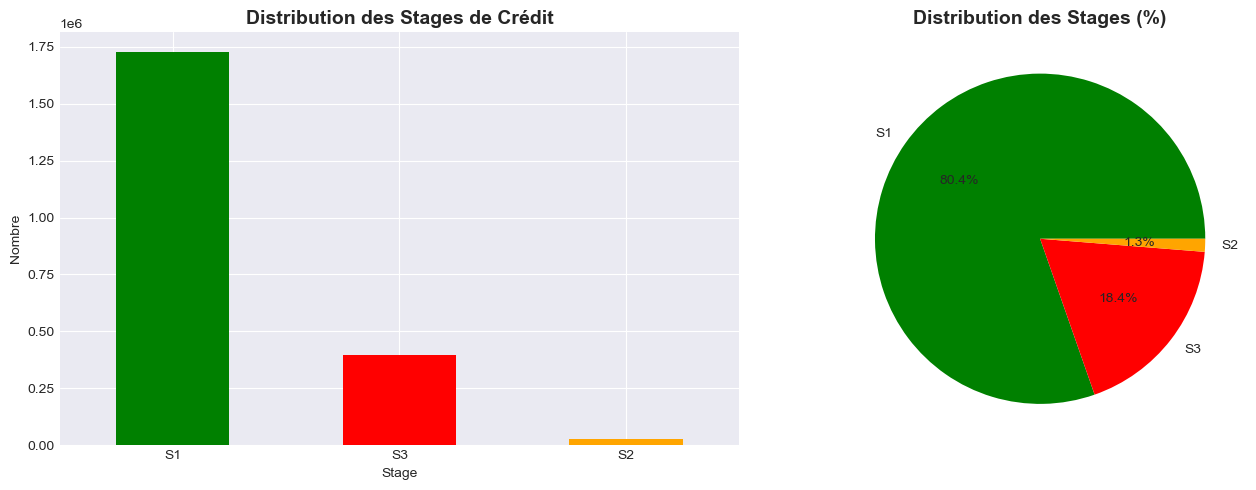

In [4]:
# Distribution des stages
stage_counts = df_credit_risk['STAGE'].value_counts()
stage_pct = 100 * stage_counts / len(df_credit_risk)

print('Distribution des Stages de Crédit:')
print('='*60)
for stage in ['S1', 'S2', 'S3']:
    if stage in stage_counts.index:
        print(f'{stage}: {stage_counts[stage]:,} ({stage_pct[stage]:.2f}%)')

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Diagramme en barres
colors = {'S1': 'green', 'S2': 'orange', 'S3': 'red'}
stage_counts.plot(kind='bar', ax=ax1, 
                  color=[colors.get(x, 'gray') for x in stage_counts.index])
ax1.set_title('Distribution des Stages de Crédit', fontsize=14, fontweight='bold')
ax1.set_xlabel('Stage')
ax1.set_ylabel('Nombre')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Diagramme circulaire
stage_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                  colors=[colors.get(x, 'gray') for x in stage_counts.index])
ax2.set_title('Distribution des Stages (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 3.2 Évolution Temporelle

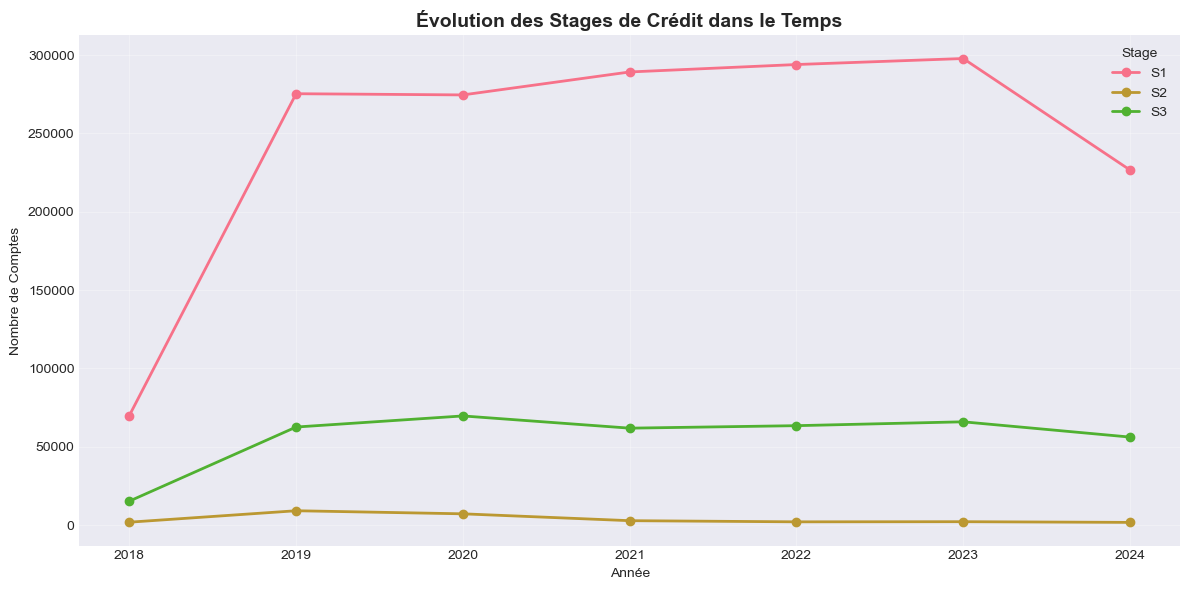

In [5]:
# Évolution dans le temps
stage_evolution = df_credit_risk.groupby(['CRIANNEE', 'STAGE']).size().reset_index(name='count')
stage_evolution_pivot = stage_evolution.pivot(index='CRIANNEE', columns='STAGE', values='count').fillna(0)

# Graphique
fig, ax = plt.subplots(figsize=(12, 6))
stage_evolution_pivot.plot(ax=ax, linewidth=2, marker='o')
ax.set_title('Évolution des Stages de Crédit dans le Temps', fontsize=14, fontweight='bold')
ax.set_xlabel('Année')
ax.set_ylabel('Nombre de Comptes')
ax.legend(title='Stage', loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
# Partie 4: Matrices de Transition des Chaînes de Markov
---

## 4.1 Créer les Transitions Trimestrielles

In [6]:
def create_quarterly_transitions_vectorized(data):
    """
    Créer les transitions trimestrielles de stages de crédit en utilisant des opérations vectorisées
    """
    # Mapper les mois aux trimestres
    month_to_quarter = {3: 'T1', 6: 'T2', 9: 'T3', 12: 'T4'}
    
    data = data.copy()
    data['TRIMESTRE'] = data['CRIMOIS'].map(month_to_quarter)
    data = data[data['TRIMESTRE'].notna()]
    
    # Trier par client et temps
    data_sorted = data.sort_values(['CLIENT_ID', 'CRIANNEE', 'CRIMOIS'])
    
    # Créer les valeurs de la période suivante en utilisant shift (vectorisé)
    data_sorted['NEXT_YEAR'] = data_sorted.groupby('CLIENT_ID')['CRIANNEE'].shift(-1)
    data_sorted['NEXT_MONTH'] = data_sorted.groupby('CLIENT_ID')['CRIMOIS'].shift(-1)
    data_sorted['NEXT_STAGE'] = data_sorted.groupby('CLIENT_ID')['STAGE'].shift(-1)
    data_sorted['NEXT_TRIMESTRE'] = data_sorted.groupby('CLIENT_ID')['TRIMESTRE'].shift(-1)
    
    # Filtrer les transitions valides (même année, trimestres consécutifs)
    valid_transitions = (
        (data_sorted['NEXT_YEAR'] == data_sorted['CRIANNEE']) &
        (data_sorted['NEXT_MONTH'] - data_sorted['CRIMOIS'] == 3) &
        data_sorted['NEXT_STAGE'].notna()
    )
    
    transitions = data_sorted[valid_transitions].copy()
    
    transitions = transitions.rename(columns={
        'CRIANNEE': 'YEAR',
        'TRIMESTRE': 'FROM_TRIMESTRE',
        'NEXT_TRIMESTRE': 'TO_TRIMESTRE',
        'STAGE': 'FROM_STAGE',
        'NEXT_STAGE': 'TO_STAGE'
    })
    
    return transitions[['CLIENT_ID', 'YEAR', 'FROM_TRIMESTRE', 'TO_TRIMESTRE', 
                        'FROM_STAGE', 'TO_STAGE']]

# Créer les transitions
print('Création des transitions trimestrielles (vectorisées)...')
transitions_df = create_quarterly_transitions_vectorized(df_credit_risk)

print(f'\n✓ Créé {len(transitions_df):,} transitions')
print(f'Années couvertes: {sorted(transitions_df["YEAR"].unique())}')
print('\nÉchantillon de transitions:')
print(transitions_df.head(10))

Création des transitions trimestrielles (vectorisées)...

✓ Créé 1,373,763 transitions
Années couvertes: [2019, 2020, 2021, 2022, 2023, 2024]

Échantillon de transitions:
           CLIENT_ID  YEAR FROM_TRIMESTRE TO_TRIMESTRE FROM_STAGE TO_STAGE
512410  B_1145exemple1  2020             T1           T2         S3       S3
165871    B_243exemple2  2019             T1           T2         S1       S1
252519    B_243exemple3  2019             T2           T3         S1       S1
339522    B_243exemple4  2019             T3           T4         S1       S1
512409    B_243exemple5  2020             T1           T2         S1       S1
600662    B_243exemple6  2020             T2           T3         S1       S1
690040    B_243exemple7  2020             T3           T4         S1       S1
865803    B_243exemple8  2021             T1           T2         S1       S1
954059    B_243exemple9  2021             T2           T3         S1       S1
87282        E_10exemple10  2019             T1      

## 4.2 Calculer les Matrices de Transition

In [7]:
def calculate_transition_matrix_vectorized(transitions_df, from_trimestre, to_trimestre):
    """
    Calculer la matrice de transition pour un trimestre spécifique en utilisant des opérations vectorisées
    """
    quarter_transitions = transitions_df[
        (transitions_df['FROM_TRIMESTRE'] == from_trimestre) &
        (transitions_df['TO_TRIMESTRE'] == to_trimestre)
    ]
    
    if quarter_transitions.empty:
        return np.eye(3)
    
    # Compter les transitions en utilisant crosstab (vectorisé)
    transition_counts = pd.crosstab(
        quarter_transitions['FROM_STAGE'],
        quarter_transitions['TO_STAGE']
    )
    
    stages = ['S1', 'S2', 'S3']
    transition_counts = transition_counts.reindex(
        index=stages, columns=stages, fill_value=0
    )
    
    # Convertir en probabilités
    row_sums = transition_counts.sum(axis=1).replace(0, 1)
    transition_matrix = transition_counts.div(row_sums, axis=0).fillna(0)
    
    # Mettre la diagonale à 1 pour les états sans transitions
    no_transitions = (transition_counts.sum(axis=1) == 0)
    for stage in stages:
        if no_transitions[stage]:
            transition_matrix.loc[stage, stage] = 1.0
    
    return transition_matrix.values

def calculate_annual_matrices(transitions_df, year):
    """
    Calculer toutes les matrices trimestrielles et la matrice annuelle pour une année donnée
    """
    year_transitions = transitions_df[transitions_df['YEAR'] == year]
    
    if year_transitions.empty:
        return {}, np.eye(3)
    
    quarterly_transitions = ['T1_T2', 'T2_T3', 'T3_T4']
    quarterly_matrices = {}
    
    for transition in quarterly_transitions:
        from_t, to_t = transition.split('_')
        matrix = calculate_transition_matrix_vectorized(
            year_transitions, from_t, to_t
        )
        quarterly_matrices[transition] = matrix
    
    # Calculer la matrice annuelle (multiplication matricielle)
    annual_matrix = quarterly_matrices['T1_T2']
    if 'T2_T3' in quarterly_matrices:
        annual_matrix = np.dot(annual_matrix, quarterly_matrices['T2_T3'])
    if 'T3_T4' in quarterly_matrices:
        annual_matrix = np.dot(annual_matrix, quarterly_matrices['T3_T4'])
    
    return quarterly_matrices, annual_matrix

def display_transition_matrix(matrix, title, stages=['S1', 'S2', 'S3']):
    """
    Afficher joliment la matrice de transition
    """
    print(f'\n{title}')
    print('=' * len(title))
    df_matrix = pd.DataFrame(matrix, index=stages, columns=stages)
    print(df_matrix)
    return df_matrix

# Calculer pour toutes les années
all_matrices = {}
years_available = sorted(transitions_df['YEAR'].unique())

print('Calcul des matrices de transition...\n')

for year in years_available:
    print(f"{'='*60}")
    print(f'ANNÉE {year}')
    print(f"{'='*60}")
    
    quarterly_matrices, annual_matrix = calculate_annual_matrices(transitions_df, year)
    
    if quarterly_matrices:
        # Afficher les matrices trimestrielles
        for quarter_name, matrix in quarterly_matrices.items():
            display_transition_matrix(matrix, f'Matrice {quarter_name} - {year}')
        
        # Afficher la matrice annuelle
        display_transition_matrix(annual_matrix, f'Matrice Annuelle {year}')
        
        # Insights clés
        print(f'\nInsights Clés {year}:')
        print(f'  • P(S1→S1) = {annual_matrix[0,0]:.4f}')
        print(f'  • P(S1→S3) = {annual_matrix[0,2]:.4f}')
        print(f'  • P(S2→S3) = {annual_matrix[1,2]:.4f}')
        
        all_matrices[year] = {
            'quarterly': quarterly_matrices,
            'annual': annual_matrix
        }
    else:
        print(f'Pas de transitions pour {year}')

Calcul des matrices de transition...

ANNÉE 2019

Matrice T1_T2 - 2019
       S1     S2     S3
S1 0.9599 0.0361 0.0040
S2 0.4743 0.2167 0.3090
S3 0.0140 0.0118 0.9742

Matrice T2_T3 - 2019
       S1     S2     S3
S1 0.9811 0.0152 0.0036
S2 0.6863 0.1601 0.1536
S3 0.0150 0.0073 0.9777

Matrice T3_T4 - 2019
       S1     S2     S3
S1 0.9861 0.0100 0.0039
S2 0.5716 0.1734 0.2550
S3 0.0162 0.0112 0.9726

Matrice Annuelle 2019
       S1     S2     S3
S1 0.9651 0.0133 0.0216
S2 0.6408 0.0176 0.3416
S3 0.0567 0.0127 0.9307

Insights Clés 2019:
  • P(S1→S1) = 0.9651
  • P(S1→S3) = 0.0216
  • P(S2→S3) = 0.3416
ANNÉE 2020

Matrice T1_T2 - 2020
       S1     S2     S3
S1 0.9728 0.0216 0.0057
S2 0.4597 0.1448 0.3955
S3 0.0111 0.0056 0.9833

Matrice T2_T3 - 2020
       S1     S2     S3
S1 0.9865 0.0093 0.0042
S2 0.7105 0.1224 0.1670
S3 0.0194 0.0116 0.9690

Matrice T3_T4 - 2020
       S1     S2     S3
S1 0.9875 0.0084 0.0042
S2 0.4661 0.2326 0.3013
S3 0.0195 0.0151 0.9654

Matrice Annuelle 2020
   

## 4.3 Validation Statistique: Test du Chi-Carré

In [8]:
def chi_square_test_transitions(transitions_df):
    """
    Effectuer un test du Chi-carré pour la validation de la propriété de Markov
    """
    contingency_table = pd.crosstab(
        transitions_df['FROM_STAGE'],
        transitions_df['TO_STAGE']
    )
    
    print('Table de Contingence:')
    print(contingency_table)
    print()
    
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
    
    print('Résultats du Test du Chi-Carré:')
    print('='*50)
    print(f'Statistique Chi-carré: {chi2:,.2f}')
    print(f'p-value: {p_value:.6f}')
    print(f'Degrés de liberté: {dof}')
    print()
    
    if p_value < 0.01:
        print('✓ CONCLUSION: Rejet de H0 (p < 0.01)')
        print('  Les transitions dépendent du stage actuel.')
        print('  Le modèle de chaîne de Markov est statistiquement valide!')
    else:
        print('✗ CONCLUSION: Échec du rejet de H0')
    
    return chi2, p_value, dof

# Effectuer le test
print('Test du Chi-Carré pour la Propriété de Markov\n')
chi2_stat, p_val, degrees = chi_square_test_transitions(transitions_df)

Test du Chi-Carré pour la Propriété de Markov

Table de Contingence:
TO_STAGE         S1    S2      S3
FROM_STAGE                       
S1          1110802  9464    5772
S2             9221  3316    4129
S3             5192  1211  224656

Résultats du Test du Chi-Carré:
Statistique Chi-carré: 1,329,117.92
p-value: 0.000000
Degrés de liberté: 4

✓ CONCLUSION: Rejet de H0 (p < 0.01)
  Les transitions dépendent du stage actuel.
  Le modèle de chaîne de Markov est statistiquement valide!


## 4.4 Calcul de la Perte de Crédit Attendue (ECL)

In [9]:
def calculate_ECL(stage, exposure, annual_matrix, LGD=0.40):
    """
    Calculer la Perte de Crédit Attendue: ECL = PD × LGD × EAD
    """
    stage_to_idx = {'S1': 0, 'S2': 1, 'S3': 2}
    idx = stage_to_idx[stage]
    
    # PD = Probabilité de transition vers S3 (défaut)
    PD = annual_matrix[idx, 2]
    ECL = PD * LGD * exposure
    
    return ECL, PD

# Exemple de calcul pour l'année la plus récente
if len(all_matrices) > 0:
    latest_year = max(all_matrices.keys())
    matrix_latest = all_matrices[latest_year]['annual']
    
    print(f'Perte de Crédit Attendue (ECL) - {latest_year}')
    print('='*60)
    print('Hypothèses: LGD = 40%, EAD = €100,000\n')
    
    exposure = 100000
    ecl_results = []
    
    for stage in ['S1', 'S2', 'S3']:
        ecl, pd_value = calculate_ECL(stage, exposure, matrix_latest)
        ecl_results.append({
            'Stage': stage,
            'PD': f'{pd_value:.4f}',
            'ECL': f'€{ecl:,.2f}'
        })
    
    ecl_df = pd.DataFrame(ecl_results)
    print(ecl_df.to_string(index=False))
    
    # Calculer le ratio
    ecl_s1, _ = calculate_ECL('S1', exposure, matrix_latest)
    ecl_s2, _ = calculate_ECL('S2', exposure, matrix_latest)
    ratio = ecl_s2 / ecl_s1 if ecl_s1 > 0 else 0
    print(f'\nECL(S2) / ECL(S1) = {ratio:.1f}x')

Perte de Crédit Attendue (ECL) - 2024
Hypothèses: LGD = 40%, EAD = €100,000

Stage     PD        ECL
   S1 0.0167    €669.26
   S2 0.3093 €12,371.30
   S3 0.9637 €38,547.79

ECL(S2) / ECL(S1) = 18.5x


---
# Partie 5: Analyse de Survie et Calcul d'Écoulement
---

Cette partie analyse le comportement d'écoulement des soldes clients en utilisant:
1. **Calcul de la durée d'annulation** pour chaque client
2. **Taux d'écoulement moyens** par période
3. **Analyse de survie Kaplan-Meier**
4. **Modèle AFT Weibull** pour prédire les temps de survie

## 5.1 Calcul de la Durée d'Annulation des Soldes

In [10]:
if df_ecoulement is not None:
    def trouver_mois_annulation(client_data):
        """
        Trouver le mois d'annulation du solde pour chaque client
        """
        resultats = []
        for annee_ref in client_data['CPGANN'].unique():
            mois_list = client_data.loc[client_data['CPGANN'] == annee_ref, ['CPGANN', 'CPGMOIS']].drop_duplicates().values.tolist()

            for start_annee, start_month in mois_list:
                if start_annee > 2024 or (start_annee == 2024 and start_month > 12):
                    continue

                base_encours = client_data.loc[
                    (client_data['CPGANN'] == start_annee) & (client_data['CPGMOIS'] == start_month),
                    'encours_debut_modif'
                ].values[0]

                cumul_pct = 0
                annulation_date = None

                for CPGANN, mois in client_data[['CPGANN', 'CPGMOIS']].drop_duplicates().values.tolist():
                    if CPGANN < start_annee or (CPGANN == start_annee and mois < start_month):
                        continue

                    # Cas particulier: départ décembre 2024
                    if start_annee == 2024 and start_month == 12:
                        if CPGANN == 2024 or CPGANN == 2025:
                            debit_mois = client_data.loc[(client_data['CPGANN'] == CPGANN) & (client_data['CPGMOIS'] == mois), 'DEBIT'].values[0]
                            pct = (debit_mois / base_encours) * 100 if base_encours != 0 else 0
                            cumul_pct += pct
                        else:
                            break
                    else:
                        debit_mois = client_data.loc[(client_data['CPGANN'] == CPGANN) & (client_data['CPGMOIS'] == mois), 'DEBIT'].values[0]
                        pct = (debit_mois / base_encours) * 100 if base_encours != 0 else 0
                        cumul_pct += pct

                    if cumul_pct >= 100:
                        annulation_date = (CPGANN, mois)
                        break

                if annulation_date:
                    resultats.append({
                        'CPGANN': start_annee,
                        'mois_depart': int(start_month),
                        'mois_annulation': annulation_date[1],
                        'annee_annulation': annulation_date[0],
                        'clt': client_data['clt'].iloc[0]
                    })
        return resultats

    # Appliquer par client
    res_all = []
    for clt, group in df_ecoulement.groupby('clt'):
        res_all.extend(trouver_mois_annulation(group))

    res_df = pd.DataFrame(res_all)

    # Afficher les résultats
    if not res_df.empty:
        print('Échantillon de résultats d\'annulation par client:')
        print(res_df.head(10))
    else:
        print('Aucun résultat trouvé.')
else:
    print('Données d\'écoulement non disponibles - passage de l\'analyse de survie')

Échantillon de résultats d'annulation par client:
   CPGANN  mois_depart  mois_annulation  annee_annulation            clt
0    2023            2                8              2023  1/ 196exemple1
1    2023            3                3              2023  1/ 196exemple2
2    2023            4                8              2023  1/ 196exemple3
3    2023            5               12              2023  1/ 196exemple4
4    2023            6               12              2023  1/ 1966exemple5
5    2023            7               12              2023  1/ 196exemple6
6    2023            8                8              2023  1/ 196exemple7
7    2023            9               12              2023  1/ 196exemple8
8    2023           10               12              2023  1/ 196exemple9
9    2023           11               12              2023  1/ 196exemple10


## 5.2 Calcul de la Durée d'Écoulement

In [11]:
if df_ecoulement is not None and 'res_df' in locals() and not res_df.empty:
    def calculer_duree(row):
        # Même année
        if row['annee_annulation'] == row['CPGANN']:
            return row['mois_annulation'] - row['mois_depart'] + 1
        else:
            mois_restant = row['mois_annulation'] + (row['annee_annulation'] - row['CPGANN']) * 12 - row['mois_depart'] + 1
            return mois_restant

    res_df['duree_ecoulement'] = res_df.apply(calculer_duree, axis=1)

    # Moyenne par client
    moyennes_clients = res_df.groupby('clt')['duree_ecoulement'].mean().reset_index()
    print('Durée moyenne d\'écoulement par client (échantillon):')
    print(moyennes_clients.head(10))

    # Moyenne globale
    moyenne_globale = res_df['duree_ecoulement'].mean()
    print(f'\nDurée moyenne d\'écoulement globale: {moyenne_globale:.2f} mois')
else:
    print('Pas de données pour le calcul de la durée')

Durée moyenne d'écoulement par client (échantillon):
             clt  duree_ecoulement
0  1/ 196exemple1            4.9565
1  1/ 196exemple2            3.1667
2  1/ 196exemple3            2.1667
3  1/ 196exemple4            1.0000
4  1/ 31exemple5            1.9048
5  1/ 445exemple6            5.7273
6  1/ 44exemple7            6.2857
7  1/ 445exemple8           27.3333
8  1/ 4450exemple9           13.3913
9  1/ 445exemple10            9.5263

Durée moyenne d'écoulement globale: 3.54 mois


## 5.3 Calcul des Taux d'Écoulement Moyens par Période

Résultats des taux d'écoulement (extrait):
            Moyenne_globale
Periode 1           53.7335
Periode 2           34.3802
Periode 3            9.5406
Periode 4            4.1064
Periode 5            2.3553
Periode 6            1.5782
Periode 7            1.1349
Periode 8            0.8441
Periode 9            0.6584
Periode 10           0.5228
Periode 11           0.4174
Periode 12           0.3404
Periode 13           0.2670
Periode 14           0.2134
Periode 15           0.1801
Periode 16           0.1534
Periode 17           0.1276
Periode 18           0.1087
Periode 19           0.0957
Periode 20           0.0781


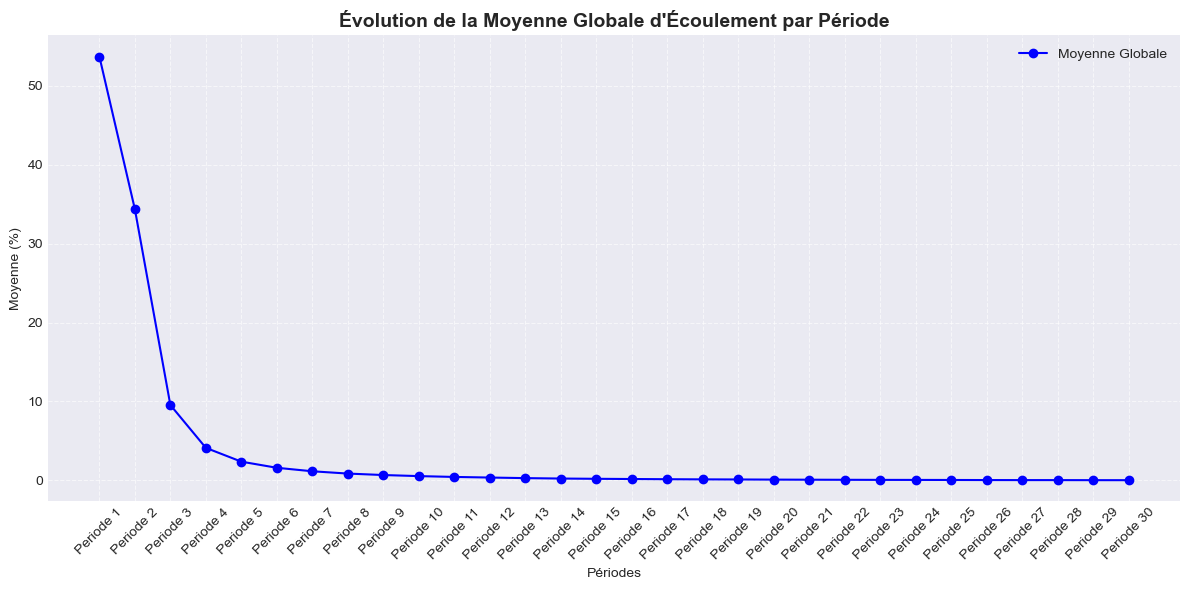


Fichier sauvegardé: C:\Users\emnat\Desktop\BTProject\Exports\resultats_ecoulement_complets.xlsx


In [12]:
if df_ecoulement is not None:
    def construire_series(client_data):
        """
        Construire des séries temporelles de taux d'écoulement pour chaque client
        """
        series = []
        mois_dispo = client_data[['CPGANN', 'CPGMOIS']].drop_duplicates().values.tolist()

        for start_annee, start_month in mois_dispo:
            base_encours = client_data.loc[
                (client_data['CPGANN'] == start_annee) & (client_data['CPGMOIS'] == start_month),
                'encours_debut_modif'
            ].values[0]

            cumul_pct = 0
            serie_pct = []

            for annee, mois in mois_dispo:
                if annee < start_annee or (annee == start_annee and mois < start_month):
                    continue

                if base_encours == 0:
                    pct = 0
                else:
                    debit_mois = client_data.loc[
                        (client_data['CPGANN'] == annee) & (client_data['CPGMOIS'] == mois),
                        'DEBIT'
                    ].values[0]
                    pct = (debit_mois / base_encours) * 100

                if cumul_pct >= 100:
                    pct = 0
                else:
                    cumul_pct += pct
                
                if pct > 100:
                    pct = 100

                serie_pct.append(pct)

            series.append(serie_pct)

        return series

    # Moyennes par période pour chaque client
    resultats = {}

    for clt, group in df_ecoulement.groupby('clt'):
        series_client = construire_series(group)
        max_len = max(len(s) for s in series_client) if series_client else 0

        moyennes_par_periode = []
        for i in range(max_len):
            valeurs_periode = [s[i] if i < len(s) else 0 for s in series_client]
            moyennes_par_periode.append(sum(valeurs_periode) / len(valeurs_periode))

        resultats[clt] = moyennes_par_periode

    # Toutes listes même longueur
    max_periodes = max(len(v) for v in resultats.values()) if resultats else 0
    for clt in resultats:
        while len(resultats[clt]) < max_periodes:
            resultats[clt].append(np.nan)

    # DataFrame final
    df_moyennes_clients = pd.DataFrame(resultats)
    df_moyennes_clients.index = [f'Periode {i+1}' for i in range(len(df_moyennes_clients))]

    # Moyenne globale par période
    df_moyennes_clients['Moyenne_globale'] = df_moyennes_clients.mean(axis=1, skipna=True)

    print('Résultats des taux d\'écoulement (extrait):')
    print(df_moyennes_clients[['Moyenne_globale']].head(20))

    # Diagramme
    plt.figure(figsize=(12, 6))
    plt.plot(df_moyennes_clients.index[:30], df_moyennes_clients['Moyenne_globale'][:30], 
             marker='o', color='blue', label='Moyenne Globale')
    plt.title('Évolution de la Moyenne Globale d\'Écoulement par Période', fontsize=14, fontweight='bold')
    plt.xlabel('Périodes')
    plt.ylabel('Moyenne (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Export
    output_path = os.path.join(r'C:\Users\emnat\Desktop\BTProject\Exports', 'resultats_ecoulement_complets.xlsx')
    df_export = df_moyennes_clients.T
    df_export.to_excel(output_path)
    print(f'\nFichier sauvegardé: {output_path}')
else:
    print('Données d\'écoulement non disponibles')

## 5.4 Analyse de Survie Kaplan-Meier

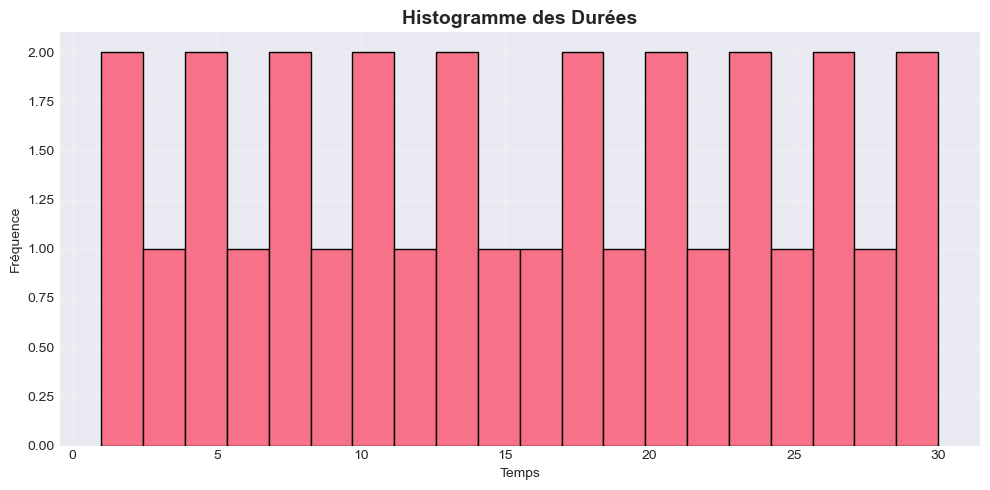

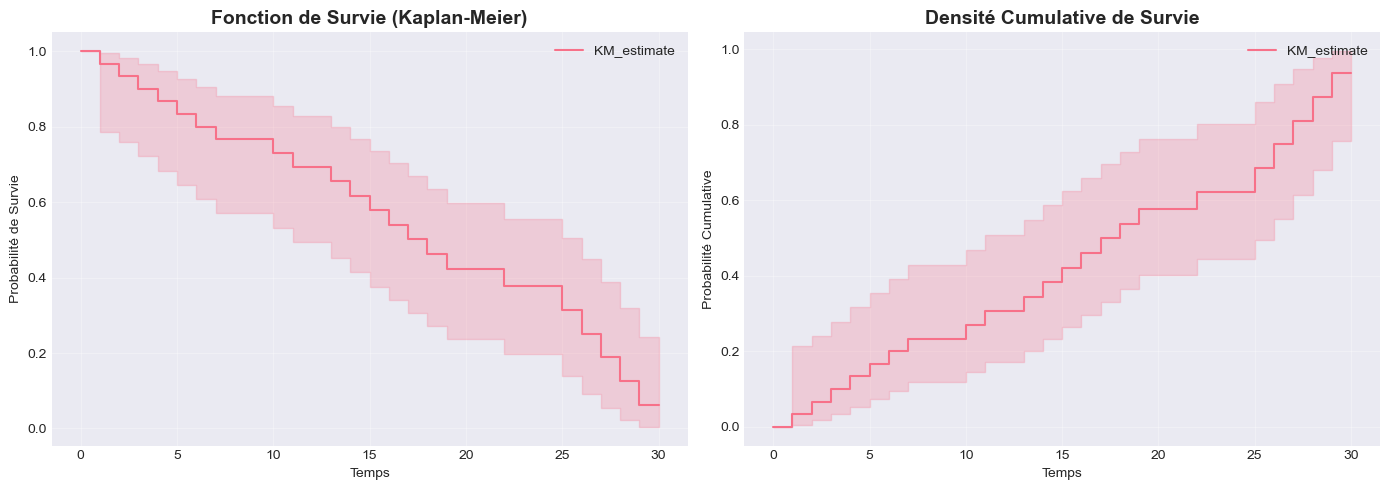

STATISTIQUES DE SURVIE (KAPLAN-MEIER)
📊 Médiane de survie: 18.00 mois
📊 Moyenne de survie (espérance): 17.48 mois

Intervalle de confiance de la médiane:
        KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5000                 11.0000                 26.0000

💡 INSIGHTS SUPPLÉMENTAIRES:

Percentiles de survie:
  • 25% des soldes épuisés à: 27.00 mois
  • 50% des soldes épuisés à: 18.00 mois
  • 75% des soldes épuisés à: 10.00 mois

Probabilité de survie à différents moments:
  • À 1 mois: 96.7% des soldes restent
  • À 3 mois: 90.0% des soldes restent
  • À 6 mois: 80.0% des soldes restent
  • À 12 mois: 69.4% des soldes restent


In [22]:
if df_ecoulement is not None:
    # Préparer les données pour l'analyse de survie
    data_survie = df_ecoulement.drop_duplicates(['CPGANN', 'CPGMOIS', 'clt'], keep='last').copy()

    # Calcul evolution et ecoulement
    data_survie['evolution'] = data_survie['CREDIT'] - data_survie['DEBIT']
    data_agg = data_survie.groupby(['CPGANN', 'CPGMOIS'], as_index=False)[['evolution', 'encours_debut_modif']].sum()

    data_agg['ecoul'] = 100 * data_agg['evolution'] / data_agg['encours_debut_modif']
    data_agg['time'] = range(1, len(data_agg) + 1)

    # Variable événement (1 = survie, 0 = annulation)
    data_agg['cible'] = (data_agg['evolution'] >= 0).astype(int)

    T = data_agg['time']
    E = data_agg['cible']

    # Histogramme des durées
    plt.figure(figsize=(10, 5))
    plt.hist(T, bins=20, edgecolor='black')
    plt.title('Histogramme des Durées', fontsize=14, fontweight='bold')
    plt.xlabel('Temps')
    plt.ylabel('Fréquence')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Kaplan-Meier
    kmf = KaplanMeierFitter()
    kmf.fit(durations=T, event_observed=E)

    # Fonction de survie
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    kmf.plot_survival_function(ax=ax1)
    ax1.set_title('Fonction de Survie (Kaplan-Meier)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Temps')
    ax1.set_ylabel('Probabilité de Survie')
    ax1.grid(alpha=0.3)

    # Densité cumulative
    kmf.plot_cumulative_density(ax=ax2)
    ax2.set_title('Densité Cumulative de Survie', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Temps')
    ax2.set_ylabel('Probabilité Cumulative')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # ========================================
    # CALCUL DES STATISTIQUES RÉELLES
    # ========================================
    
    # Médiane de survie
    median_ = kmf.median_survival_time_
    median_conf_interval = median_survival_times(kmf.confidence_interval_)
    
    # Espérance de vie (moyenne) - calcul manuel
    # L'espérance est l'intégrale de la courbe de survie
    survival_function = kmf.survival_function_
    moyenne_survie = survival_function['KM_estimate'].sum()
    
    # OU utiliser la méthode de lifelines si disponible
    try:
        # Certaines versions ont cette méthode
        moyenne_survie_alt = kmf.percentile(0.5)
    except:
        moyenne_survie_alt = None
    
    # Affichage des résultats
    print('='*60)
    print('STATISTIQUES DE SURVIE (KAPLAN-MEIER)')
    print('='*60)
    print(f'📊 Médiane de survie: {median_:.2f} mois')
    print(f'📊 Moyenne de survie (espérance): {moyenne_survie:.2f} mois')
    print(f'\nIntervalle de confiance de la médiane:')
    print(median_conf_interval)
    print('='*60)
    
    # Statistiques supplémentaires utiles pour la présentation
    print('\n💡 INSIGHTS SUPPLÉMENTAIRES:')
    
    # Temps où 25%, 50%, 75% des soldes sont épuisés
    percentiles = [0.25, 0.50, 0.75]
    print('\nPercentiles de survie:')
    for p in percentiles:
        try:
            time_at_p = kmf.percentile(p)
            print(f'  • {int(p*100)}% des soldes épuisés à: {time_at_p:.2f} mois')
        except:
            print(f'  • {int(p*100)}%: Non calculable')
    
    # Probabilité de survie à différents moments
    print('\nProbabilité de survie à différents moments:')
    time_points = [1, 3, 6, 12]
    for t in time_points:
        if t <= T.max():
            prob = kmf.survival_function_at_times(t).values[0]
            print(f'  • À {t} mois: {prob*100:.1f}% des soldes restent')
    
    print('='*60)
    
else:
    print('Données d\'écoulement non disponibles')

## 5.5 Comparaison des Modèles Paramétriques

In [23]:
if df_ecoulement is not None and 'data_agg' in locals():
    # Comparaison des modèles paramétriques
    wb = WeibullFitter()
    ex = ExponentialFitter()
    log = LogNormalFitter()
    loglogis = LogLogisticFitter()

    model_comparison = []
    
    for model in [wb, ex, log, loglogis]:
        model.fit(durations=data_agg['time'], event_observed=data_agg['cible'])
        model_comparison.append({
            'Modèle': model.__class__.__name__,
            'AIC': model.AIC_
        })
        print(f'AIC pour {model.__class__.__name__}: {model.AIC_:.2f}')
    
    # Afficher le meilleur modèle
    best_model = min(model_comparison, key=lambda x: x['AIC'])
    print(f'\n✓ Meilleur modèle: {best_model["Modèle"]} (AIC = {best_model["AIC"]:.2f})')
else:
    print('Données non disponibles pour la comparaison des modèles')

AIC pour WeibullFitter: 177.62
AIC pour ExponentialFitter: 180.24
AIC pour LogNormalFitter: 182.94
AIC pour LogLogisticFitter: 181.81

✓ Meilleur modèle: WeibullFitter (AIC = 177.62)


## 5.6 Modèle Weibull AFT (Accelerated Failure Time)

Résumé du Modèle Weibull AFT:


<lifelines.WeibullAFTFitter: fitted with 30 total observations, 8 right-censored observations>
             duration col = 'time'
                event col = 'cible'
   number of observations = 30
number of events observed = 22
           log-likelihood = -57.344
         time fit was run = 2025-11-10 15:38:27 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                
lambda_ CPGANN                  1.019     2.770     0.126           0.771           1.267               2.162               3.549
        CPGMOIS                 0.114     1.121     0.022           0.071           0.157               1.073               1.170
        ecoul                  -0.359     0.699     0.255          -0.858           0.140               0.424               1.151
        encours_debut_modif    -0.000     1.000     0.000          -0.000           0.000               1.000               1.000
        evolution               0.000     1.000     0.000          -0.000           0.000               1.000               1.000
        Intercept           -2059.297     0.000   255.358       -2559.790       -1558.804               0.000               0.000
rho_    Intercept               1.532     4.627     0.183           1.174           1.890               3.235               6.618

                             cmp to      z       p  -log2(p)
param   covariate                                           
lambda_ CPGANN                0.000  8.062 <0.0005    50.245
        CPGMOIS               0.000  5.171 <0.0005    22.032
        ecoul                 0.000 -1.409   0.159     2.653
        encours_debut_modif   0.000 -0.671   0.502     0.994
        evolution             0.000  1.348   0.178     2.492
        Intercept             0.000 -8.064 <0.0005    50.271
rho_    Intercept             0.000  8.392 <0.0005    54.215
---
Concordance = 0.985
AIC = 128.687
log-likelihood ratio test = 58.937 on 5 df
-log2(p) of ll-ratio test = 35.530

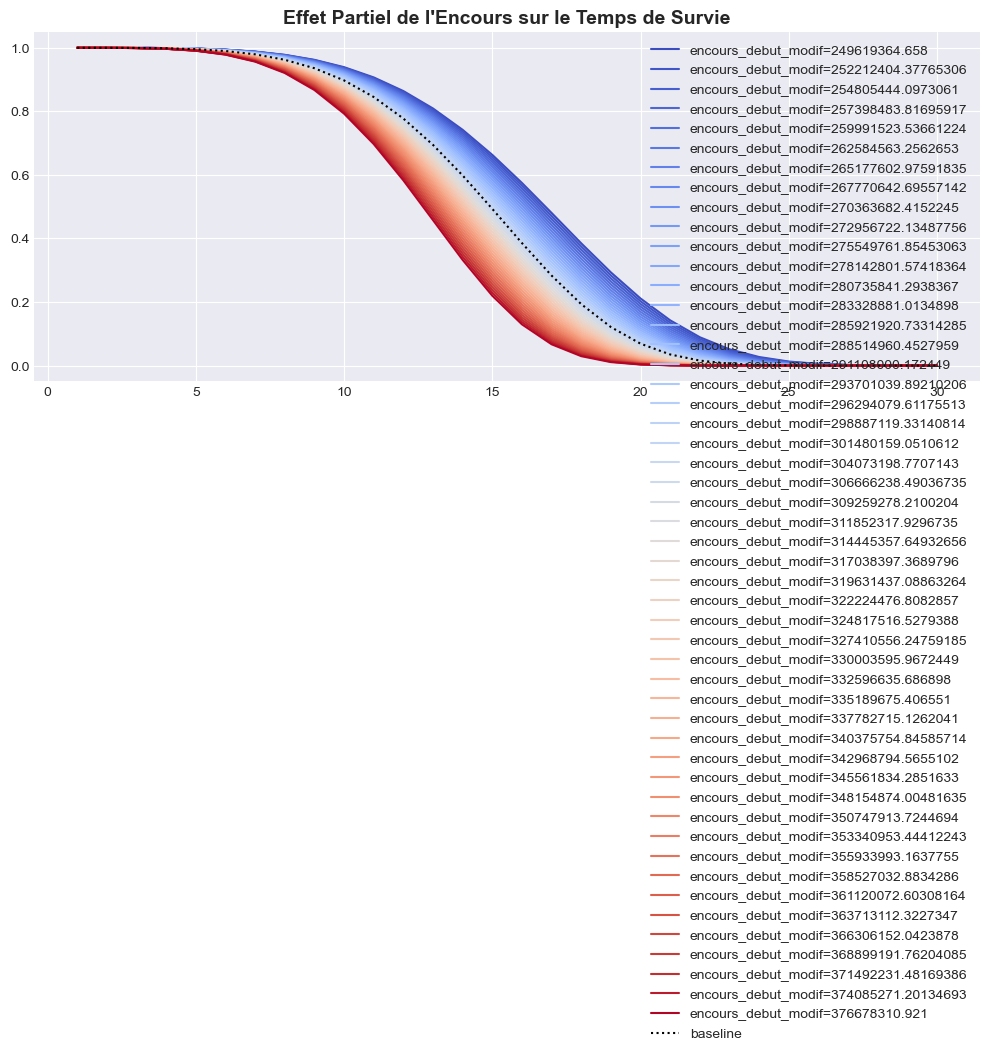

In [24]:
if df_ecoulement is not None and 'data_agg' in locals():
    # Modèle Weibull AFT
    weibull_aft = WeibullAFTFitter()
    weibull_aft.fit(data_agg, duration_col='time', event_col='cible')
    
    print('Résumé du Modèle Weibull AFT:')
    print('='*60)
    weibull_aft.print_summary(3)

    # Effet partiel sur le temps de survie
    if 'encours_debut_modif' in data_agg.columns:
        plt.figure(figsize=(10, 8))
        weibull_aft.plot_partial_effects_on_outcome('encours_debut_modif', 
                                                     values=np.linspace(data_agg['encours_debut_modif'].min(),
                                                                       data_agg['encours_debut_modif'].max(),
                                                                       50),
                                                     cmap='coolwarm')
        plt.title('Effet Partiel de l\'Encours sur le Temps de Survie', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print('Données non disponibles pour le modèle AFT')

## 5.7 Calcul de la Value at Risk (VaR)

Calcul de la Value at Risk (VaR):
VaR historique (1%): -250,500,203.59
VaR gaussien (1%): -233,849,606.34


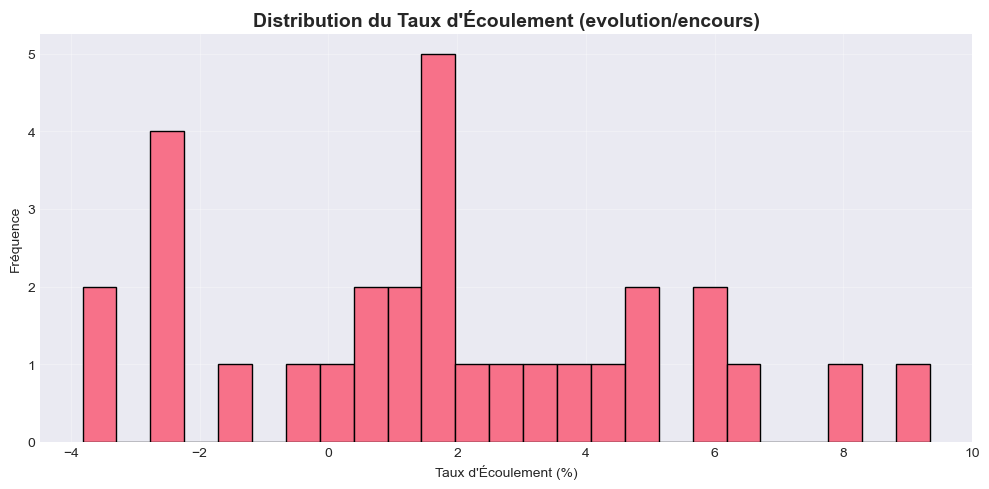

In [25]:
if df_ecoulement is not None and 'data_agg' in locals():
    def var_historic(r, level):
        """
        Calculer la VaR historique
        """
        if isinstance(r, pd.DataFrame):
            return r.aggregate(var_historic, level=level)
        elif isinstance(r, pd.Series):
            return -np.percentile(r, level)
        else:
            raise TypeError('Expected r to be a Series or DataFrame')

    def var_gaussian(r, level, modified=False):
        """
        Calculer la VaR gaussienne
        """
        z = norm.ppf(level/100)
        if modified:
            s = skew(r)
            k = kurtosis(r)
            z = (z +
                 (z**2 - 1)*s/6 +
                 (z**3 -3*z)*(k-3)/24 -
                 (2*z**3 - 5*z)*(s**2)/36)
        return -(r.mean() + z*r.std(ddof=0))

    print('Calcul de la Value at Risk (VaR):')
    print('='*60)
    print(f'VaR historique (1%): {var_historic(data_agg["encours_debut_modif"], 1):,.2f}')
    print(f'VaR gaussien (1%): {var_gaussian(data_agg["encours_debut_modif"], 1, modified=False):,.2f}')

    # Histogramme des taux d'écoulement
    plt.figure(figsize=(10, 5))
    data_agg['ecoul'].hist(bins=25, edgecolor='black')
    plt.title('Distribution du Taux d\'Écoulement (evolution/encours)', fontsize=14, fontweight='bold')
    plt.xlabel('Taux d\'Écoulement (%)')
    plt.ylabel('Fréquence')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('Données non disponibles pour le calcul de la VaR')

---
# Partie 6: Machine Learning pour la Prévision des Transitions
---

## 6.1 Préparer le Dataset ML

In [26]:
# Créer la cible binaire: dégradation (1) ou stable/amélioration (0)
stage_order = {'S1': 1, 'S2': 2, 'S3': 3}
transitions_ml = transitions_df.copy()
transitions_ml['from_stage_num'] = transitions_ml['FROM_STAGE'].map(stage_order)
transitions_ml['to_stage_num'] = transitions_ml['TO_STAGE'].map(stage_order)
transitions_ml['degradation'] = (transitions_ml['to_stage_num'] > transitions_ml['from_stage_num']).astype(int)

# Features: stage actuel, année, trimestre
X = pd.get_dummies(transitions_ml[['from_stage_num', 'YEAR', 'FROM_TRIMESTRE']], 
                   columns=['FROM_TRIMESTRE'])
y = transitions_ml['degradation']

print(f'Dataset ML:')
print(f'  Échantillons: {len(X):,}')
print(f'  Features: {X.shape[1]}')
print(f'  Cas de dégradation: {y.sum():,} ({100*y.mean():.2f}%)')
print(f'  Cas stables: {(~y.astype(bool)).sum():,} ({100*(1-y.mean()):.2f}%)')

Dataset ML:
  Échantillons: 1,373,763
  Features: 5
  Cas de dégradation: 19,365 (1.41%)
  Cas stables: 1,354,398 (98.59%)


## 6.2 Entraîner les Modèles

In [27]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Définir les modèles
models = {
    'Régression Logistique': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Entraîner et évaluer
results = {}

print('Entraînement des modèles...\n')

for name, model in models.items():
    # Entraîner
    model.fit(X_train, y_train)
    
    # Prédire
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
    
    print(f'{name}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-Score: {f1:.4f}')
    print(f'  ROC-AUC: {roc_auc:.4f}')
    print()

# Comparaison
comparison_df = pd.DataFrame(results).T
print('\nComparaison des Modèles:')
print(comparison_df.sort_values('roc_auc', ascending=False))

Entraînement des modèles...

Régression Logistique:
  Accuracy: 0.9859
  F1-Score: 0.0000
  ROC-AUC: 0.5702

Random Forest:
  Accuracy: 0.9859
  F1-Score: 0.0000
  ROC-AUC: 0.7781

Gradient Boosting:
  Accuracy: 0.9859
  F1-Score: 0.0000
  ROC-AUC: 0.7779


Comparaison des Modèles:
                       accuracy  f1_score  roc_auc
Random Forest            0.9859    0.0000   0.7781
Gradient Boosting        0.9859    0.0000   0.7779
Régression Logistique    0.9859    0.0000   0.5702


---
# Partie 7: Export des Résultats
---

In [28]:
# Créer le répertoire d'export
EXPORT_DIR = r'C:\Users\emnat\Desktop\BTProject\Exports'
os.makedirs(EXPORT_DIR, exist_ok=True)

print('Export des résultats...\n')

# 1. Export des matrices de transition
matrices_export = []
for year, data in all_matrices.items():
    matrix = data['annual']
    for i, from_stage in enumerate(['S1', 'S2', 'S3']):
        for j, to_stage in enumerate(['S1', 'S2', 'S3']):
            matrices_export.append({
                'Year': year,
                'From_Stage': from_stage,
                'To_Stage': to_stage,
                'Probability': matrix[i, j]
            })

df_matrices = pd.DataFrame(matrices_export)
output_path = os.path.join(EXPORT_DIR, 'transition_matrices.xlsx')
df_matrices.to_excel(output_path, index=False)
print(f'✓ Matrices de transition: {output_path}')

# 2. Export de la performance des modèles
output_path2 = os.path.join(EXPORT_DIR, 'model_performance.xlsx')
comparison_df.to_excel(output_path2)
print(f'✓ Performance des modèles: {output_path2}')

# 3. Export des résultats de survie (si disponibles)
if df_ecoulement is not None and 'res_df' in locals() and not res_df.empty:
    output_path3 = os.path.join(EXPORT_DIR, 'survival_analysis_results.xlsx')
    res_df.to_excel(output_path3, index=False)
    print(f'✓ Résultats analyse de survie: {output_path3}')

print(f'\nTous les exports sauvegardés dans: {EXPORT_DIR}')

Export des résultats...

✓ Matrices de transition: C:\Users\emnat\Desktop\BTProject\Exports\transition_matrices.xlsx
✓ Performance des modèles: C:\Users\emnat\Desktop\BTProject\Exports\model_performance.xlsx
✓ Résultats analyse de survie: C:\Users\emnat\Desktop\BTProject\Exports\survival_analysis_results.xlsx

Tous les exports sauvegardés dans: C:\Users\emnat\Desktop\BTProject\Exports


---
# Partie 8: Résumé et Conclusions
---

In [29]:
print('='*80)
print('RÉSUMÉ DU PROJET')
print('='*80)
print()
print('Sources de Données:')
print(f'  1. Données de Risque de Crédit: {len(df_credit_risk):,} enregistrements')
if df_ecoulement is not None:
    print(f'  2. Données d\'Écoulement: {len(df_ecoulement):,} enregistrements')
print()
print('Livrables:')
print(f'  • Matrices de transition: {len(all_matrices)} années')
print(f'  • Modèles ML entraînés: {len(models)}')
print(f'  • Meilleure accuracy: {comparison_df["accuracy"].max():.2%}')
print(f'  • Meilleur ROC-AUC: {comparison_df["roc_auc"].max():.4f}')
if df_ecoulement is not None and 'moyenne_globale' in locals():
    print(f'  • Durée moyenne d\'écoulement: {moyenne_globale:.2f} mois')
print()
print('✓ Projet complété avec succès!')
print('='*80)

RÉSUMÉ DU PROJET

Sources de Données:
  1. Données de Risque de Crédit: 2,149,936 enregistrements
  2. Données d'Écoulement: 706,154 enregistrements

Livrables:
  • Matrices de transition: 6 années
  • Modèles ML entraînés: 3
  • Meilleure accuracy: 98.59%
  • Meilleur ROC-AUC: 0.7781
  • Durée moyenne d'écoulement: 3.54 mois

✓ Projet complété avec succès!


In [31]:
print('='*80)
print('RÉCAPITULATIF DE TOUS LES CHIFFRES POUR LA PRÉSENTATION')
print('='*80)

# 1. Distribution des stages
print('\n📊 SLIDE 5 - Distribution des Stages:')
stage_counts = df_credit_risk['STAGE'].value_counts()
stage_pct = 100 * stage_counts / len(df_credit_risk)
for stage in ['S1', 'S2', 'S3']:
    if stage in stage_counts.index:
        print(f'  {stage}: {stage_pct[stage]:.1f}%')

# 2. Matrice 2024 (déjà calculée)
print('\n📊 SLIDE 6 - Matrice 2024: ✅ DÉJÀ CORRECT')

# 3. Chi-carré (déjà calculé)
print('\n📊 SLIDE 7 - Chi-carré: ✅ DÉJÀ CORRECT')

# 4. ECL (déjà calculé)
print('\n📊 SLIDE 8 - ECL: ✅ DÉJÀ CORRECT')

# 5. Analyse de survie
if df_ecoulement is not None and 'kmf' in locals():
    print('\n📊 SLIDE 9 - Analyse de Survie:')
    median_ = kmf.median_survival_time_
    survival_function = kmf.survival_function_
    moyenne_survie = survival_function['KM_estimate'].sum()
    print(f'  Médiane: {median_:.2f} mois')
    print(f'  Moyenne: {moyenne_survie:.2f} mois')

# 6. Comparaison modèles
if df_ecoulement is not None and 'data_agg' in locals():
    print('\n📊 SLIDE 10 - AIC des Modèles:')
    from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
    
    models_to_test = {
        'Weibull': WeibullFitter(),
        'Exponentiel': ExponentialFitter(),
        'Log-Normal': LogNormalFitter(),
        'Log-Logistic': LogLogisticFitter()
    }
    
    for name, model in models_to_test.items():
        model.fit(durations=data_agg['time'], event_observed=data_agg['cible'])
        print(f'  {name}: AIC = {model.AIC_:.2f}')

# 7. ML (déjà calculé)
print('\n📊 SLIDE 11 - ML: ✅ DÉJÀ CORRECT')

print('\n📊 SLIDES 13-16 - Dashboard Power BI:')
print('  ❌ OUVREZ BTDashboard.pbix ET NOTEZ LES CHIFFRES MANUELLEMENT')

print('\n' + '='*80)
print('RÉSUMÉ: Copiez ces chiffres dans votre présentation PowerPoint')
print('='*80)

RÉCAPITULATIF DE TOUS LES CHIFFRES POUR LA PRÉSENTATION

📊 SLIDE 5 - Distribution des Stages:
  S1: 80.4%
  S2: 1.3%
  S3: 18.4%

📊 SLIDE 6 - Matrice 2024: ✅ DÉJÀ CORRECT

📊 SLIDE 7 - Chi-carré: ✅ DÉJÀ CORRECT

📊 SLIDE 8 - ECL: ✅ DÉJÀ CORRECT

📊 SLIDE 9 - Analyse de Survie:
  Médiane: 18.00 mois
  Moyenne: 17.48 mois

📊 SLIDE 10 - AIC des Modèles:
  Weibull: AIC = 177.62
  Exponentiel: AIC = 180.24
  Log-Normal: AIC = 182.94
  Log-Logistic: AIC = 181.81

📊 SLIDE 11 - ML: ✅ DÉJÀ CORRECT

📊 SLIDES 13-16 - Dashboard Power BI:
  ❌ OUVREZ BTDashboard.pbix ET NOTEZ LES CHIFFRES MANUELLEMENT

RÉSUMÉ: Copiez ces chiffres dans votre présentation PowerPoint
